In [2]:
import numpy as np
import scipy as p
import matplotlib.pyplot as plt
from scipy.odr import ODR, Model, RealData
from scipy import odr

In [ ]:
def STLSQ(Theta: np.ndarray,dXdt: np.ndarray, lambd: float, n_iter: int = 10) -> np.ndarray:
                                                        
    # Initial ordinary least-squares fit
    Xi, *_ = np.linalg.lstsq(Theta, dXdt, rcond=None)

    for _ in range(n_iter):
        # Hard-threshold small coefficients
        smallinds = np.abs(Xi) < lambd
        Xi[smallinds] = 0.0

        # For each state variable, refit using the remaining “large” basis functions
        for ind in range(Xi.shape[1]):      # n = Xi.shape[1]
            biginds = ~smallinds[:, ind]    # True means this basis function is kept
            if not np.any(biginds):
                continue                    # Skip if the entire column was zeroed
            Xi[biginds, ind], *_ = np.linalg.lstsq(
                Theta[:, biginds],          # Reduced library matrix
                dXdt[:, ind],               # Target derivative for this state
                rcond=None
            )

    return Xi


True coefficients:      [ 3.  -2.   0.   0.5  0.   1. ]
Recovered coefficients: [ 3.01960013 -2.08989875 -0.20507489  0.84404811  0.25640407  0.70278417]
λ (threshold) chosen:   0.18456740206273323


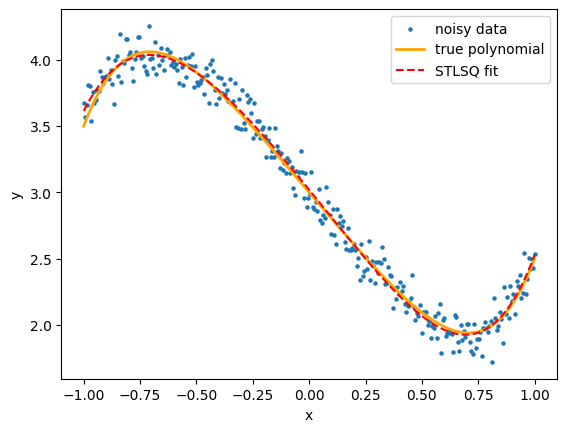

In [5]:
np.random.seed(0)

m = 300                                   # number of samples
x = np.linspace(-1, 1, m)
true_coeffs = np.array([3.0, -2.0, 0.0, 0.5, 0.0, 1])   # up to x^5
deg = len(true_coeffs) - 1
y_clean = sum(c * x**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.1 * np.random.randn(m)               # add y-noise only

# Build polynomial library Θ(x) = [1, x, x^2, …, x^deg]
Theta = np.vstack([x**k for k in range(deg + 1)]).T        # m × (deg+1)

# Choose λ slightly below the smallest non-zero coefficient
Xi_initial, *_ = np.linalg.lstsq(Theta, y_noisy[:, None], rcond=None)
nz = np.abs(Xi_initial)[np.abs(Xi_initial) > 1e-12]        # filter exact zeros
lambd = 0.9*nz.min()                                     # 90% of smallest non-zero

Xi_sparse = STLSQ(Theta, y_noisy[:, None], lambd=lambd, n_iter=10).ravel()    # flatten to 1-D

print("True coefficients:     ", true_coeffs)
print("Recovered coefficients:", Xi_sparse)
print("λ (threshold) chosen:  ", lambd)

y_fit = sum(Xi_sparse[k] * x**k for k in range(deg + 1))
plt.scatter(x, y_noisy, s=5, label='noisy data')
plt.plot(x, y_clean, color='orange', linewidth=2, label='true polynomial')
plt.plot(x, y_fit, '--', color='red', linewidth=1.5, label='STLSQ fit')
plt.legend(); plt.xlabel('x'); plt.ylabel('y'); plt.show()

True  coeffs: [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.98803894 -2.00904345  0.          0.52705949  0.03702859  0.98104567]
Chosen λ: 0.00650967523045817


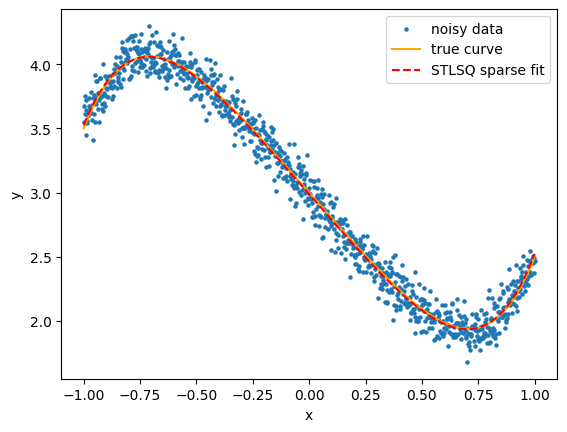

In [6]:
np.random.seed(0)
m = 1000
x = np.linspace(-1, 1, m)
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])   
deg = len(true_coeffs) - 1
y_clean = sum(c * x**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.1 * np.random.randn(m)

#  Construct and normalize the polynomial library
Theta = np.vstack([x**k for k in range(deg + 1)]).T
col_norms = np.linalg.norm(Theta, axis=0)
Theta_n = Theta                    # Normalize each column to unit norm
y = y_noisy[:, None]


# λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)                # 0.001 → 1
best_bic, best_Xi, best_lam = np.inf, None, None
n = len(y_noisy)

for lam in lambdas:
    Xi_n = STLSQ(Theta_n, y, lam)               # Sparse regression on normalized library

    rss = np.sum((y_noisy - (Theta @ Xi_n).ravel())**2)
    k = np.count_nonzero(Xi_n)                    # # Number of non-zero coefficients
    bic = n * np.log(rss / n) + k * np.log(n)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi_n.ravel(), lam

#
print("True  coeffs:", true_coeffs)
print("Sparse coeffs:", best_Xi)
print("Chosen λ:", best_lam)

y_fit = sum(best_Xi[k] * x**k for k in range(deg + 1))
plt.scatter(x, y_noisy, s=5, label="noisy data")
plt.plot(x, y_clean, color = "orange", lw=1.5, label="true curve")
plt.plot(x, y_fit, "--", color = "red", lw=1.5, label="STLSQ sparse fit")
plt.legend(); plt.xlabel("x"); plt.ylabel("y"); plt.show()

In [6]:

def _odr_fit(A: np.ndarray, b: np.ndarray, beta0: np.ndarray | None = None) -> np.ndarray:
 
    # polynomial model
    def poly_model(beta, x):
        return np.dot(beta, x)

    model = odr.Model(poly_model)
    data  = odr.RealData(A.T, b, sx= 0.1, sy = 0.1)           

    if beta0 is None:                       # LSQ as the initial value
        beta0 = np.linalg.lstsq(A, b, rcond=None)[0]
    out = odr.ODR(data, model, beta0=beta0).run()
    return out.beta


def STLSQ_ODR(Theta: np.ndarray,
              dXdt: np.ndarray,
              lambd: float,
              n_iter: int = 10) -> np.ndarray:

    n_features, n_states = Theta.shape[1], dXdt.shape[1]
    Xi = np.zeros((n_features, n_states))

    # ODR fit
    for k in range(n_states):
        Xi[:, k] = _odr_fit(Theta, dXdt[:, k])

    # Iteration: thresholding + refitting
    for _ in range(n_iter):
        small = np.abs(Xi) < lambd
        Xi[small] = 0.0

        # Large coefficients retained by re-ODR fitting for each state
        for k in range(n_states):
            keep = ~small[:, k]
            if not np.any(keep):
                continue
            Xi[keep, k] = _odr_fit(Theta[:, keep], dXdt[:, k])

    return Xi

In [2]:
def _odr_fit(x: np.ndarray,
             b: np.ndarray,
             true_coeffs,
             deg: int,
             beta0: np.ndarray | None = None,
             sx: float | np.ndarray = 0.06,
             sy: float | np.ndarray = 0.1) -> np.ndarray:
 
    # polynomial model
    def poly_model(beta, x):
        y = np.zeros_like(x, dtype=float)
        for i, c in enumerate(beta):
            y += c * x**i
        return y
        
    model = odr.Model(poly_model)
    data  = odr.RealData(x, b, sx= sx, sy = sy)           

    if beta0 is None:     # LSQ as the initial value
        deg = len(true_coeffs) - 1                       
        A = np.vstack([x**k for k in range(deg + 1)]).T
        beta0 = np.linalg.lstsq(A, b, rcond=None)[0]
    out = odr.ODR(data, model, beta0=beta0).run()
    return out.beta


def STLSQ_ODR(x: np.ndarray,
              dXdt: np.ndarray,
              deg: int,
              lambd: float,
              n_iter: int = 10,
              sx: float = 0.06,
              sy: float = 0.1) -> np.ndarray:
    """
    Sparse thresholded polynomial regression (SINDy/STLSQ + ODR)
    """
   
    Theta = np.vstack([x**k for k in range(deg + 1)]).T   # (N, deg+1)
    n_features, n_states = Theta.shape[1], dXdt.shape[1]
    Xi = np.zeros((n_features, n_states))

    dummy_coeffs = np.empty(deg + 1)     
    for k in range(n_states):
        Xi[:, k] = _odr_fit(x,
                            dXdt[:, k],
                            true_coeffs=dummy_coeffs,
                            deg=deg,
                            sx=sx, sy=sy)

    # iteration
    for _ in range(n_iter):
        small = np.abs(Xi) < lambd
        Xi[small] = 0.0
        for k in range(n_states):
            keep = ~small[:, k]
            if not np.any(keep):
                continue

            powers_kept = np.flatnonzero(keep)
            deg_sub     = int(powers_kept[-1])

            sub_coeffs = _odr_fit(x,
                                  dXdt[:, k],
                                  true_coeffs=np.empty(deg_sub + 1),
                                  deg=deg_sub,
                                  sx=sx, sy=sy)
            Xi[powers_kept, k] = sub_coeffs[powers_kept]

    return Xi

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.994  -1.995   0.      0.4645  0.      1.0299]
Chosen λ     : 0.02982471286216891


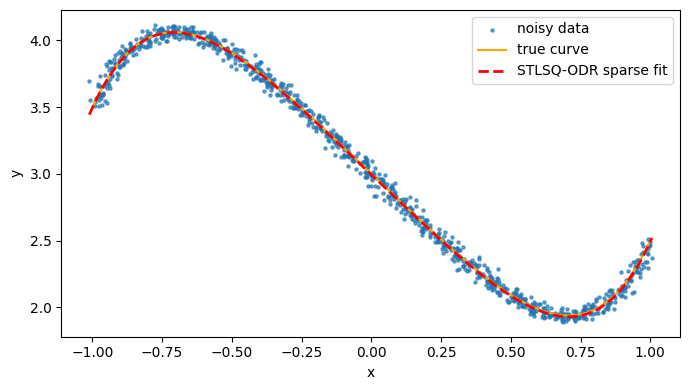

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 3.0005 -2.0063  0.      0.5225  0.      0.9862]
Chosen λ     : 0.02641536234997961


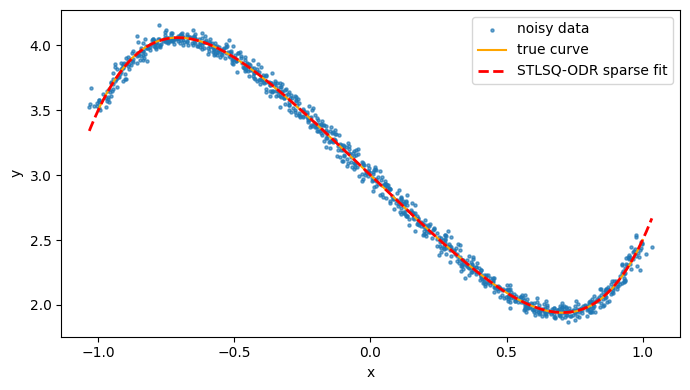

In [24]:
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x  + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add noise in both x and y
x_noisy = x_true + 0.02 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.03 * np.random.randn(m)
y = y_noisy[:, None]  

# -----------------------------------------
# λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)      # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

# Design matrix Θ for computing RSS
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

for lam in lambdas:
    # Sparse regression
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)

    # Residual sum of squares
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(best_Xi, 4))
print("Chosen λ     :", best_lam)
y_fit = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy),
         y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2,
         label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout()
plt.show()






true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

x_noisy = x_true + 0.02 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.03 * np.random.randn(m)
y = y_noisy[:, None]          # (m,1)

# Build design matrix Θ(x) = [1, x, x², …, x^deg]
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -------------------------------------------------
# Choose λ  = 0.9 * (smallest non-zero |OLS coef|)
# -------------------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)  # (deg+1,1)
nz          = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]  # filter exact zeros
lambd       = 0.9 * nz.min()

# Sparse regression (STLSQ-ODR)
Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1   # both x & y noises
).ravel()

# Results & plot
print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(Xi_sparse, 4))
print("Chosen λ     :", lambd)

y_fit = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy),
         y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2,
         label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout(); plt.show()

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.9849 -2.0005  0.      0.5055  0.      0.9626]
Chosen λ     : 0.0760949668545988


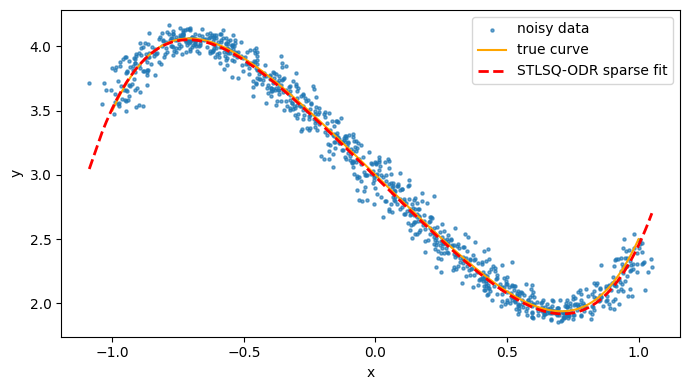

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 3.0002 -2.0273  0.      0.6387  0.054   0.8613]
Chosen λ     : 0.0426597706935175


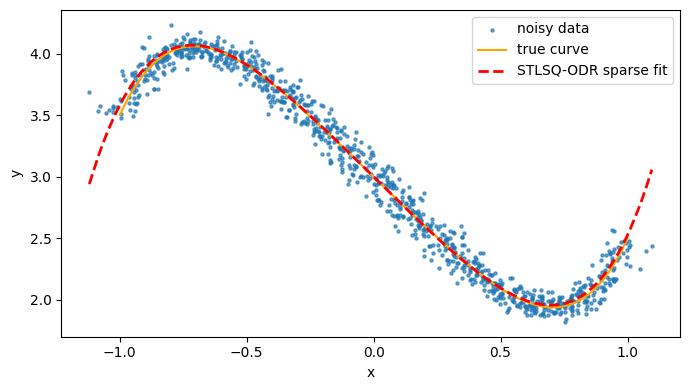

In [20]:
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x  + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add noise in both x and y
x_noisy = x_true + 0.05 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.05 * np.random.randn(m)
y = y_noisy[:, None]  

# -----------------------------------------
# λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)      # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

# Design matrix Θ for computing RSS
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

for lam in lambdas:
    # Sparse regression
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)

    # Residual sum of squares
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(best_Xi, 4))
print("Chosen λ     :", best_lam)
y_fit = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy),
         y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2,
         label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout()
plt.show()






true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

x_noisy = x_true + 0.05 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.05 * np.random.randn(m)
y = y_noisy[:, None]          # (m,1)

# Build design matrix Θ(x) = [1, x, x², …, x^deg]
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -------------------------------------------------
# Choose λ  = 0.9 * (smallest non-zero |OLS coef|)
# -------------------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)  # (deg+1,1)
nz          = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]  # filter exact zeros
lambd       = 0.9 * nz.min()

# Sparse regression (STLSQ-ODR)
Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1   # both x & y noises
).ravel()

# Results & plot
print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(Xi_sparse, 4))
print("Chosen λ     :", lambd)

y_fit = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy),
         y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2,
         label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout(); plt.show()

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.9867 -1.9508  0.      0.1653  0.      1.316 ]
Chosen λ     : 0.04237587160604064


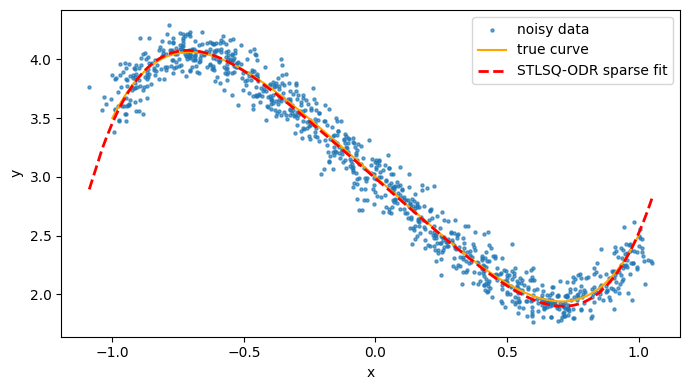

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.9862 -1.9678  0.0502  0.286  -0.0515  1.1837]
Chosen λ     : 0.027632714865796926


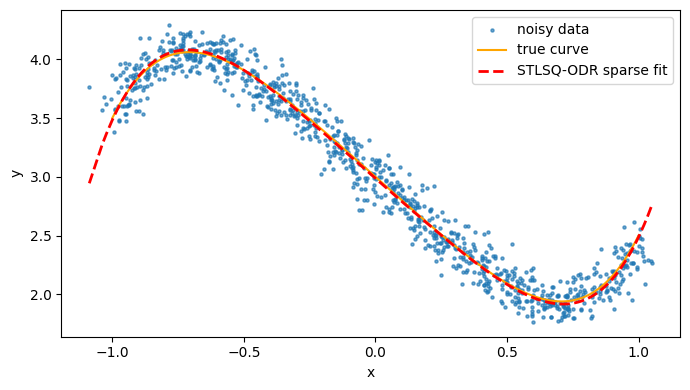

In [13]:
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x  + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add noise in both x and y
x_noisy = x_true + 0.05 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.1 * np.random.randn(m)
y = y_noisy[:, None]  

# -----------------------------------------
# λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)      # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

# Design matrix Θ for computing RSS
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

for lam in lambdas:
    # Sparse regression
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)

    # Residual sum of squares
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(best_Xi, 4))
print("Chosen λ     :", best_lam)
y_fit = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy),
         y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2,
         label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout()
plt.show()


np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

x_noisy = x_true + 0.05 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.1 * np.random.randn(m)
y = y_noisy[:, None]          # (m,1)

# Build design matrix Θ(x) = [1, x, x², …, x^deg]
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -------------------------------------------------
# Choose λ  = 0.9 * (smallest non-zero |OLS coef|)
# -------------------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)  # (deg+1,1)
nz          = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]  # filter exact zeros
lambd       = 0.9 * nz.min()

# Sparse regression (STLSQ-ODR)
Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1   # both x & y noises
).ravel()

# Results & plot
print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(Xi_sparse, 4))
print("Chosen λ     :", lambd)

y_fit = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy),
         y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2,
         label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout(); plt.show()

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.9695 -1.9997  0.      0.5254  0.      0.8645]
Chosen λ     : 0.1536174946671828


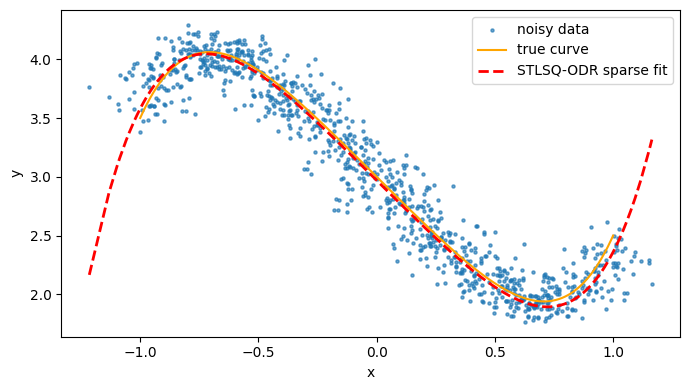

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.9707 -2.0291  0.1212  0.7154 -0.1263  0.6722]
Chosen λ     : 0.019529395094603875


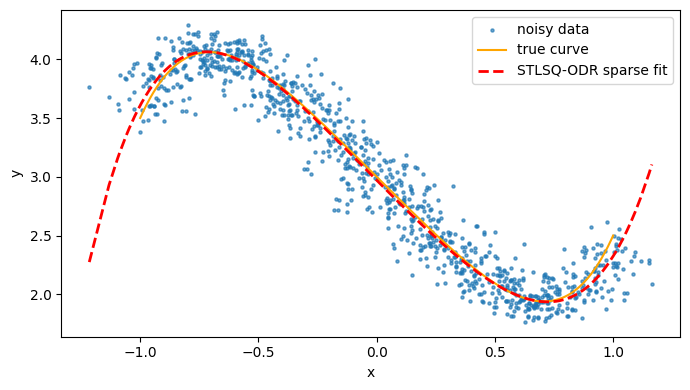

In [15]:
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x  + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add noise in both x and y
x_noisy = x_true + 0.1 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.1 * np.random.randn(m)
y = y_noisy[:, None]  

# -----------------------------------------
# λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)      # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

# Design matrix Θ for computing RSS
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

for lam in lambdas:
    # Sparse regression
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)

    # Residual sum of squares
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(best_Xi, 4))
print("Chosen λ     :", best_lam)
y_fit = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy),
         y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2,
         label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout()
plt.show()


np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

x_noisy = x_true + 0.1 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.1 * np.random.randn(m)
y = y_noisy[:, None]          # (m,1)

# Build design matrix Θ(x) = [1, x, x², …, x^deg]
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -------------------------------------------------
# Choose λ  = 0.9 * (smallest non-zero |OLS coef|)
# -------------------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)  # (deg+1,1)
nz          = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]  # filter exact zeros
lambd       = 0.9 * nz.min()

# Sparse regression (STLSQ-ODR)
Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1   # both x & y noises
).ravel()

# Results & plot
print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(Xi_sparse, 4))
print("Chosen λ     :", lambd)

y_fit = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy),
         y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2,
         label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout(); plt.show()

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.9431 -2.412   0.      2.1604  0.     -0.5694]
Chosen λ     : 0.19414919457438817


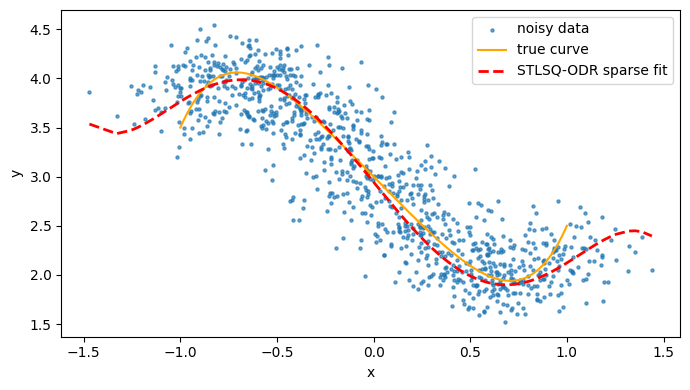

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.9517 -2.3243  0.1344  2.0646 -0.0765 -0.5754]
Chosen λ     : 0.012057940949605883


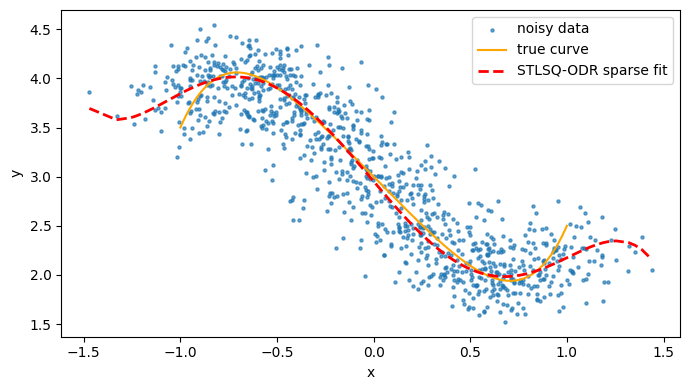

In [16]:
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x  + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add noise in both x and y
x_noisy = x_true + 0.2 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.2 * np.random.randn(m)
y = y_noisy[:, None]  

# -----------------------------------------
# λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)      # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

# Design matrix Θ for computing RSS
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

for lam in lambdas:
    # Sparse regression
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)

    # Residual sum of squares
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(best_Xi, 4))
print("Chosen λ     :", best_lam)
y_fit = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy),
         y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2,
         label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout()
plt.show()

np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

x_noisy = x_true + 0.2 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.2 * np.random.randn(m)
y = y_noisy[:, None]          # (m,1)

# Build design matrix Θ(x) = [1, x, x², …, x^deg]
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -------------------------------------------------
# Choose λ  = 0.9 * (smallest non-zero |OLS coef|)
# -------------------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)  # (deg+1,1)
nz          = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]  # filter exact zeros
lambd       = 0.9 * nz.min()

# Sparse regression (STLSQ-ODR)
Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1   # both x & y noises
).ravel()

# Results & plot
print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(Xi_sparse, 4))
print("Chosen λ     :", lambd)

y_fit = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy),
         y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2,
         label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout(); plt.show()

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.9451 -2.5313  0.      2.504   0.     -0.7616]
Chosen λ     : 0.12154742500762872


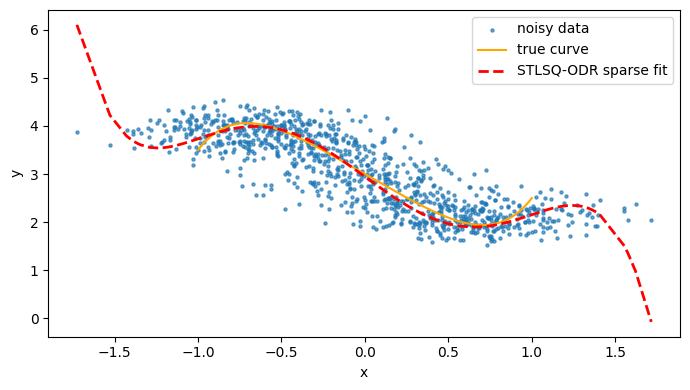

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.958  -2.3693  0.0576  2.2748  0.     -0.7093]
Chosen λ     : 0.005459154942483635


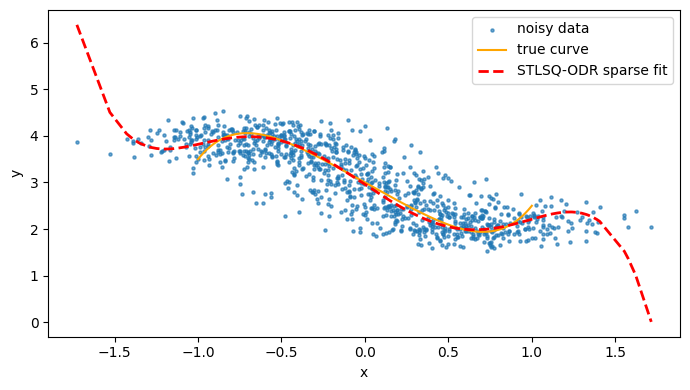

In [25]:
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x  + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add noise in both x and y
x_noisy = x_true + 0.3 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.2 * np.random.randn(m)
y = y_noisy[:, None]  

# -----------------------------------------
# λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)      # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

# Design matrix Θ for computing RSS
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

for lam in lambdas:
    # Sparse regression
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)

    # Residual sum of squares
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(best_Xi, 4))
print("Chosen λ     :", best_lam)
y_fit = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy),
         y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2,
         label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout()
plt.show()

np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

x_noisy = x_true + 0.3 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.2 * np.random.randn(m)
y = y_noisy[:, None]          # (m,1)

# Build design matrix Θ(x) = [1, x, x², …, x^deg]
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -------------------------------------------------
# Choose λ  = 0.9 * (smallest non-zero |OLS coef|)
# -------------------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)  # (deg+1,1)
nz          = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]  # filter exact zeros
lambd       = 0.9 * nz.min()

# Sparse regression (STLSQ-ODR)
Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1   # both x & y noises
).ravel()

# Results & plot
print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(Xi_sparse, 4))
print("Chosen λ     :", lambd)

y_fit = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy),
         y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2,
         label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout(); plt.show()

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.9852 -1.1211  0.      0.      0.      0.    ]
Chosen λ     : 1.0


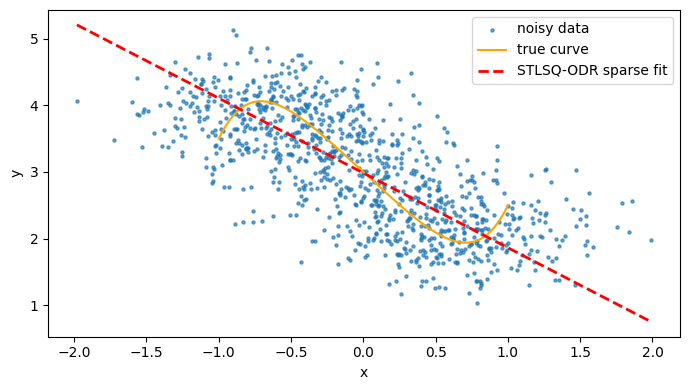

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.9771 -2.9674  0.0496  2.8432 -0.0281 -0.6981]
Chosen λ     : 0.02420094141199163


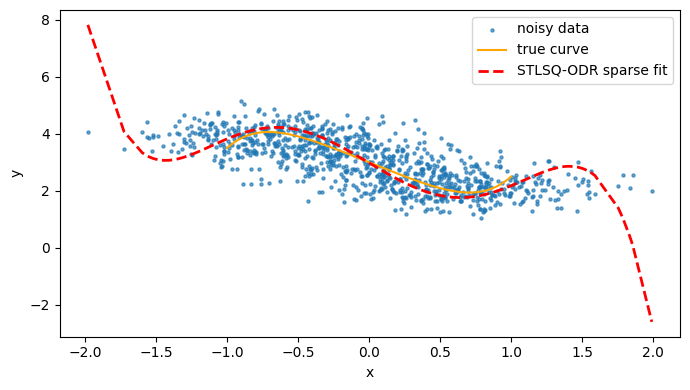

In [26]:
np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

# true polynomial: y = 3 - 2x  + 0·x² + 0.5x³ + 0·x⁴ + 1·x⁵
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

# add noise in both x and y
x_noisy = x_true + 0.4 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.4 * np.random.randn(m)
y = y_noisy[:, None]  

# -----------------------------------------
# λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)      # 0.001 → 1.0
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

# Design matrix Θ for computing RSS
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

for lam in lambdas:
    # Sparse regression
    Xi = STLSQ_ODR(x_noisy, y, deg, lambd=lam, n_iter=10)

    # Residual sum of squares
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam

print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(best_Xi, 4))
print("Chosen λ     :", best_lam)
y_fit = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy),
         y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2,
         label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout()
plt.show()

np.random.seed(0)
m = 1000
x_true = np.linspace(-1, 1, m)

true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1

x_noisy = x_true + 0.4 * np.random.randn(m)
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.4 * np.random.randn(m)
y = y_noisy[:, None]          # (m,1)

# Build design matrix Θ(x) = [1, x, x², …, x^deg]
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T

# -------------------------------------------------
# Choose λ  = 0.9 * (smallest non-zero |OLS coef|)
# -------------------------------------------------
Xi_ols, *_ = np.linalg.lstsq(Theta, y, rcond=None)  # (deg+1,1)
nz          = np.abs(Xi_ols)[np.abs(Xi_ols) > 1e-12]  # filter exact zeros
lambd       = 0.9 * nz.min()

# Sparse regression (STLSQ-ODR)
Xi_sparse = STLSQ_ODR(
    x_noisy, y, deg,
    lambd=lambd,
    n_iter=10,
    sx=0.05, sy=0.1   # both x & y noises
).ravel()

# Results & plot
print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(Xi_sparse, 4))
print("Chosen λ     :", lambd)

y_fit = sum(Xi_sparse[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy),
         y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2,
         label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout(); plt.show()

In [4]:
import numpy as np
import itertools
from scipy import odr


def _get_poly_terms(x: np.ndarray, deg: int):
    """
    Generate polynomial features up to total degree `deg` for each sample in x
    x: (n_samples, n_inputs)
    return: (n_samples, n_terms), list of exponents
    """
    n_samples, n_inputs = x.shape
    # all combinations of exponents with total degree <= deg
    powers = [p for d in range(deg + 1)
                for p in itertools.product(range(d + 1), repeat=n_inputs)
                if sum(p) == d]

    X_poly = np.zeros((n_samples, len(powers)))
    for i, power in enumerate(powers):
        X_poly[:, i] = np.prod(x ** power, axis=1)
    return X_poly, powers


def _poly_model_factory(powers):
    def model(beta, x_flat):
        x = x_flat.reshape(-1, len(powers[0]))
        y = np.zeros(x.shape[0])
        for i, power in enumerate(powers):
            y += beta[i] * np.prod(x ** power, axis=1)
        return y
    return model


def _odr_fit(x: np.ndarray,
             b: np.ndarray,
             true_coeffs,
             deg: int,
             beta0: np.ndarray | None = None,
             sx: float | np.ndarray = 0.06,
             sy: float | np.ndarray = 0.1) -> np.ndarray:

    X_poly, powers = _get_poly_terms(x, deg)
    model = odr.Model(_poly_model_factory(powers))
    data = odr.RealData(x=x.reshape(-1, x.shape[1]).T, y=b, sx=sx, sy=sy)

    if beta0 is None:
        beta0 = np.linalg.lstsq(X_poly, b, rcond=None)[0]

    out = odr.ODR(data, model, beta0=beta0).run()
    return out.beta, powers


def STLSQ_ODR(x: np.ndarray,
              dXdt: np.ndarray,
              deg: int,
              lambd: float,
              n_iter: int = 10,
              sx: float = 0.06,
              sy: float = 0.1) -> np.ndarray:

    X_poly, powers = _get_poly_terms(x, deg)
    n_features, n_states = X_poly.shape[1], dXdt.shape[1]
    Xi = np.zeros((n_features, n_states))

    dummy_coeffs = np.empty(n_features)
    for k in range(n_states):
        Xi[:, k], _ = _odr_fit(x,
                               dXdt[:, k],
                               true_coeffs=dummy_coeffs,
                               deg=deg,
                               sx=sx, sy=sy)

    for _ in range(n_iter):
        small = np.abs(Xi) < lambd
        Xi[small] = 0.0

        for k in range(n_states):
            keep = ~small[:, k]
            if not np.any(keep):
                continue

            kept_powers = [powers[i] for i in range(len(powers)) if keep[i]]
            def sub_model(beta, x_flat):
                x = x_flat.reshape(-1, x.shape[1])
                y = np.zeros(x.shape[0])
                for i, power in enumerate(kept_powers):
                    y += beta[i] * np.prod(x ** power, axis=1)
                return y

            data = odr.RealData(x=x.T, y=dXdt[:, k], sx=sx, sy=sy)
            beta0 = Xi[keep, k]
            model = odr.Model(sub_model)
            out = odr.ODR(data, model, beta0=beta0).run()
            Xi[keep, k] = out.beta

    return Xi



In [8]:
def STLSQ_ODR(x: np.ndarray,
              dXdt: np.ndarray,
              deg: int,
              lambd: float,
              n_iter: int = 10,
              sx: float = 0.06,
              sy: float = 0.1) -> np.ndarray:

    X_poly, powers = _get_poly_terms(x, deg)
    n_samples, n_inputs = x.shape
    n_features, n_states = X_poly.shape[1], dXdt.shape[1]
    Xi = np.zeros((n_features, n_states))

    dummy_coeffs = np.empty(n_features)
    for k in range(n_states):
        Xi[:, k], _ = _odr_fit(x,
                               dXdt[:, k],
                               true_coeffs=dummy_coeffs,
                               deg=deg,
                               sx=sx, sy=sy)

    for _ in range(n_iter):
        small = np.abs(Xi) < lambd
        Xi[small] = 0.0

        for k in range(n_states):
            keep = ~small[:, k]
            if not np.any(keep):
                continue

            kept_powers = [powers[i] for i in range(len(powers)) if keep[i]]
            def sub_model(beta, x_flat):
                x = x_flat.reshape(-1, n_inputs)  # ✅ FIX HERE
                y = np.zeros(x.shape[0])
                for i, power in enumerate(kept_powers):
                    y += beta[i] * np.prod(x ** power, axis=1)
                return y

            data = odr.RealData(x=x.T, y=dXdt[:, k], sx=sx, sy=sy)
            beta0 = Xi[keep, k]
            model = odr.Model(sub_model)
            out = odr.ODR(data, model, beta0=beta0).run()
            Xi[keep, k] = out.beta

    return Xi


In [5]:
from scipy.integrate import odeint
from itertools import combinations_with_replacement

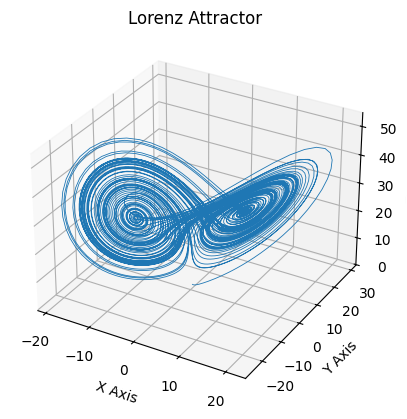

In [5]:
# initial code from wikipedia
def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.6)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [12]:
### Dataset

def lorenz63(state, t, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return (dxdt, dydt, dzdt)

# Integrate
sigma, rho, beta = 10.0, 28.0, 8 / 3
x0 = (-8, 8, 27)
dt = 0.01
t  = np.arange(0.0, 10 + dt, dt)
X_true = odeint(lorenz63, x0, t, args=(sigma, rho, beta)) # Trajectory


# add noise
noise_level = 0.01
rng = np.random.default_rng(0)
X_noisy = X_true + noise_level * rng.standard_normal(X_true.shape)

# Estimate using a second-order central difference
dXdt = np.gradient(X_noisy, dt, axis=0, edge_order=2)


➜  Best λ = 1

ẋ = +1.309y -1.015x
ẏ = -5.2791 +4.713y -4.135x
ż = 


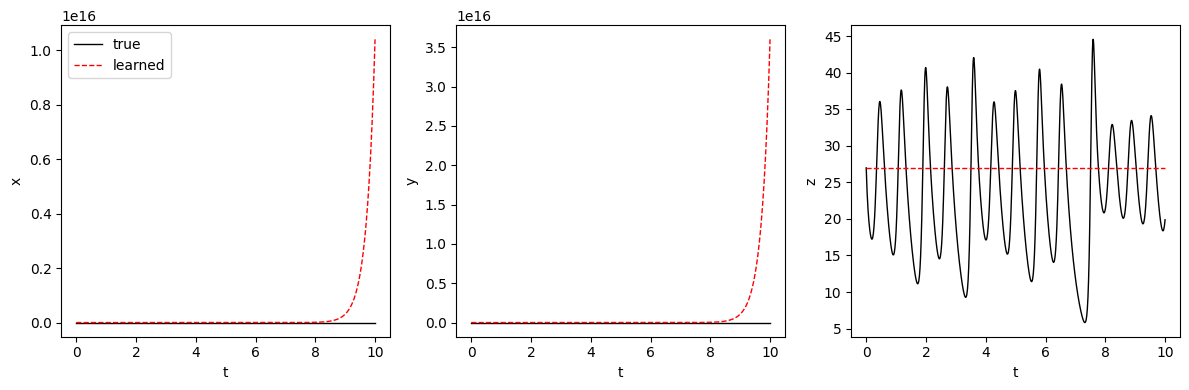

In [14]:
# λ grid search with BIC
degree = 2
lambdas = np.logspace(-3, 0, 60)
best_bic = np.inf
best_Xi = None
best_lam = None
n_samples = len(t)

for lam in lambdas:
    Xi = STLSQ_ODR(X_noisy, dXdt, deg=degree, lambd=lam, n_iter=10)
    Theta, powers = _get_poly_terms(X_noisy, degree)
    rss = np.sum((dXdt - Theta @ Xi) ** 2)
    k = np.count_nonzero(Xi)
    bic = n_samples * np.log(rss / n_samples + 1e-12) + k * np.log(n_samples)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi, lam


# model
var_names = ['x', 'y', 'z']
term_names = ['*'.join(f'{var_names[j]}' * e for j, e in enumerate(p) if e > 0) or '1' for p in powers]

print(f"\n➜  Best λ = {best_lam:.3g}\n")
for state_name, coeffs in zip(["ẋ", "ẏ", "ż"], best_Xi.T):
    terms = [f"{c:+.3f}{n}" for c, n in zip(coeffs, term_names) if abs(c) > 1e-3]
    print(f"{state_name} = {' '.join(terms)}")


# Verification track
def rhs_learned(state, t, Xi=best_Xi, deg=degree):
    theta_row, _ = _get_poly_terms(np.array(state).reshape(1, -1), deg)
    return (theta_row @ Xi).flatten().tolist()

X_learned = odeint(rhs_learned, X_noisy[0], t)


fig = plt.figure(figsize=(12, 4))
for i, lbl in enumerate('xyz'):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.plot(t, X_true[:, i], 'k', lw=1, label='true')
    ax.plot(t, X_learned[:, i], '--r', lw=1, label='learned')
    if i == 0:
        ax.legend()
    ax.set_xlabel('t')
    ax.set_ylabel(lbl)
plt.tight_layout()
plt.show()